### Representation similarity by attention: 
For each pair of features within dimension, can look at representation similarity between features (Pearson's correlation of averaged population activity)
Can plot a distribution of them, split by max vs. not. 
Expect to see: when max valued, feature representations are more dissimilar

In [24]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.visualization_utils as visualization_utils

import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
from utils.session_data import SessionData
import utils.io_utils as io_utils
from constants.behavioral_constants import *
import json

from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

import matplotlib.pyplot as plt
import matplotlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import plotly.express as px


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
# the output directory to store the data
OUTPUT_DIR = "/data/patrick_res/pseudo"
# path to a dataframe of sessions to analyze
# SESSIONS_PATH = "/data/patrick_scratch/multi_sess/valid_sessions.pickle"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
# path for each session, specifying behavior
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
# path for each session, for spikes that have been pre-aligned to event time and binned. 
# SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_residual_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"

EVENT = "FeedbackOnset"  # event in behavior to align on
PRE_INTERVAL = 1300   # time in ms before event
POST_INTERVAL = 1500  # time in ms after event
INTERVAL_SIZE = 50  # size of interval in ms

In [84]:
valid_sess = pd.read_pickle(SESSIONS_PATH)
units = spike_utils.get_unit_positions(valid_sess)
region_units = units

In [85]:
# FEATURE_DIM = "Shape"
COND_TO_SPLIT = "MaxFeatMatches"
# CONDITIONS = [COND_TO_SPLIT, FEATURE_DIM]
NUM_UNIQUE_CONDITIONS = 8
# FILTERS = {"RPEGroup": "less pos"}
FILTERS = {"Response": "Correct"}
DECODER_SEED=42
MIN_NUM_TRIALS = 20


def get_feat_beh(session, feat, shuffle):
    feat_beh = behavioral_utils.get_beh_model_labels_for_session_feat(session, feat, beh_path=SESS_BEHAVIOR_PATH)
    if shuffle:
        rng = np.random.default_rng(seed=DECODER_SEED)
        vals = feat_beh[COND_TO_SPLIT].values
        rng.shuffle(vals)
        feat_beh[COND_TO_SPLIT] = vals
    return feat_beh


def label_and_balance_sessions(session, features, feature_dim, shuffle, balance):
    feat_behs = []
    for feat in features:
        feat_behs.append(get_feat_beh(session, feat, shuffle))
    beh = pd.concat(feat_behs)
    # subselect for correct 
    for filter_col, filter in FILTERS.items():
        beh = beh[beh[filter_col] == filter]
    conditions_cols = [COND_TO_SPLIT, feature_dim]
    enough_trials = behavioral_utils.validate_enough_trials_by_condition(
        beh, 
        conditions_cols, 
        MIN_NUM_TRIALS, 
        num_unique_conditions=NUM_UNIQUE_CONDITIONS
    )
    if not enough_trials:
        print(f"Not enough trials for session {session}, skipping")
        return None
    if balance: 
        beh = behavioral_utils.balance_trials_by_condition(beh, conditions_cols)
    frs_path = SESS_SPIKES_PATH.format(
        sess_name=session, 
        pre_interval=PRE_INTERVAL, 
        event=EVENT, 
        post_interval=POST_INTERVAL, 
        interval_size=INTERVAL_SIZE
    )
    frs = pd.read_pickle(frs_path)
    frs["PseudoUnitID"] = int(session) * 100 + frs["UnitID"]
    frs = frs[frs.PseudoUnitID.isin(region_units.PseudoUnitID)]
    merged = pd.merge(beh, frs, on="TrialNumber")
    if len(merged) == 0:
        return None
    return merged



In [86]:
feature_dim = "Color"
res = valid_sess.apply(lambda x: label_and_balance_sessions(x.session_name, POSSIBLE_FEATURES[feature_dim], feature_dim, shuffle=False, balance=True), axis=1)
res = res.dropna()
all_trials = pd.concat(res.values)

Not enough trials for session 20180709, skipping
Not enough trials for session 20180920, skipping
Not enough trials for session 20181008, skipping
Not enough trials for session 20180801, skipping
Not enough trials for session 201807250001, skipping
Not enough trials for session 20180808, skipping
Not enough trials for session 20180926, skipping
Not enough trials for session 20180705, skipping
Not enough trials for session 20181004, skipping
Not enough trials for session 20181003, skipping
Not enough trials for session 20181010, skipping
Not enough trials for session 20180917, skipping
Not enough trials for session 20180712, skipping
Not enough trials for session 20180910, skipping


In [87]:
print(f"Sessions: {len(all_trials.Session.unique())} Units: {len(all_trials.PseudoUnitID.unique())}")

Sessions: 13 Units: 356


In [88]:
groupby_cols = [COND_TO_SPLIT, feature_dim, "PseudoUnitID", "TimeBins"]
conditioned_frs = all_trials.groupby(groupby_cols).FiringRate.mean().to_frame("ConditionedFiringRate").reset_index()

In [89]:
def calc_representational_sim_for_features(df, feature_dim):
    cors = []
    for i in range(4):
        for j in range(i+1, 4):
            feat_i = POSSIBLE_FEATURES[feature_dim][i]
            feat_j = POSSIBLE_FEATURES[feature_dim][j]
            frs_i = df[df[feature_dim] == feat_i].sort_values(by="PseudoUnitID")
            frs_j = df[df[feature_dim] == feat_j].sort_values(by="PseudoUnitID")
            coefs = np.corrcoef([frs_i.ConditionedFiringRate.values, frs_j.ConditionedFiringRate.values])
            cors.append(coefs[0, 1])
    return cors

In [90]:
num_pairs = 6
time_bins = conditioned_frs.TimeBins.unique()
time_bins.sort()
num_time_bins = len(time_bins)
max_mat = np.empty((num_time_bins, 6))
not_max_mat = np.empty((num_time_bins, 6))
for time_bin_idx, time_bin in enumerate(time_bins):
    maxes = conditioned_frs[np.isclose(conditioned_frs.TimeBins, time_bin) & (conditioned_frs[COND_TO_SPLIT])]
    not_maxes = conditioned_frs[np.isclose(conditioned_frs.TimeBins, time_bin) & (~conditioned_frs[COND_TO_SPLIT])]
    max_rep_sim = calc_representational_sim_for_features(maxes, feature_dim)
    not_max_rep_sim = calc_representational_sim_for_features(not_maxes, feature_dim)
    max_mat[time_bin_idx, :] = max_rep_sim
    not_max_mat[time_bin_idx, :] = not_max_rep_sim


Text(0, 0.5, 'RS')

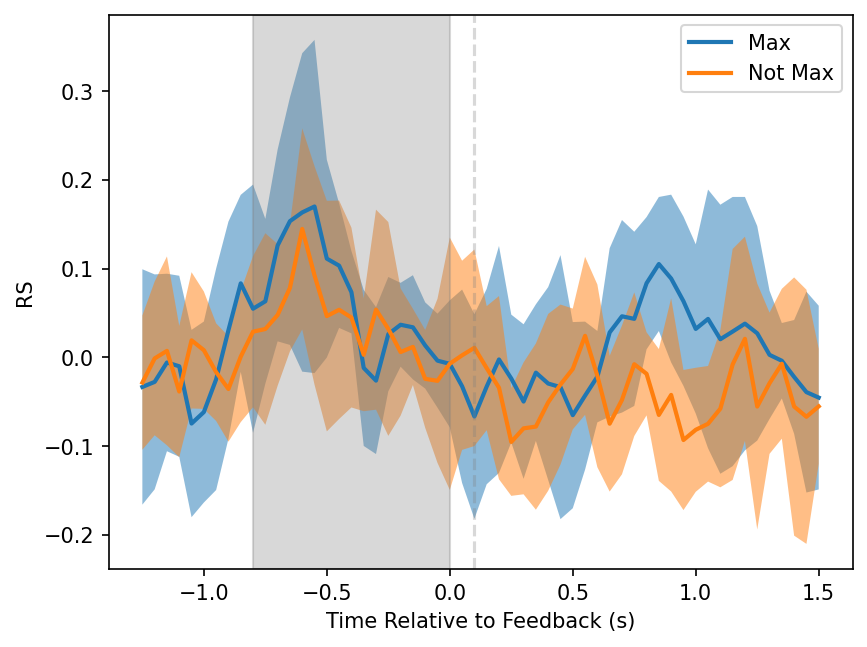

In [91]:
fig, ax = plt.subplots(dpi=150)
visualization_utils.visualize_accuracy_across_time_bins(
    max_mat,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label="Max",
    right_align=True, 
    # sem=True,
)
visualization_utils.visualize_accuracy_across_time_bins(
    not_max_mat,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label="Not Max",
    right_align=True, 
    # sem=True,
)
ax.legend()
# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
# ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("RS")